# Gym Member Churn Prediction Model

This notebook builds a machine learning model to predict which gym members are at risk of cancelling their membership.

**Approach:**
1. Load user information and visit data
2. Engineer features from visit patterns (frequency, recency, trends)
3. Combine with user demographics
4. Train a classification model
5. Analyze feature importance to understand churn drivers


In [1]:
# Imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Add project root to path for imports
sys.path.insert(0, str(Path.cwd().parent))

# Feature engineering from auxiliar module
from auxiliar.auxiliar import engineer_features

# Model functions from churn_model
from src.churn_model import (
    train_churn_model,
    evaluate_model,
    get_feature_importance,
    predict_churn_risk,
    save_model,
    FEATURE_COLUMNS
)

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load data
data_dir = Path.cwd().parent / 'data'

users_df = pd.read_csv(data_dir / 'user_information.csv', parse_dates=['REGISTRATION_DATE', 'MEMBERSHIP_END_DATE'])
visits_df = pd.read_csv(data_dir / 'user_visits.csv', parse_dates=['ENTRY_TIME', 'EXIT_TIME'])

print(f"Users: {len(users_df)}")
print(f"Visits: {len(visits_df)}")
print(f"\nUsers columns: {users_df.columns.tolist()}")
print(f"\nChurned: {users_df['MEMBERSHIP_END_DATE'].notna().sum()}")
print(f"Active: {users_df['MEMBERSHIP_END_DATE'].isna().sum()}")


Users: 300
Visits: 3790

Users columns: ['USER_ID', 'REGISTRATION_DATE', 'MEMBERSHIP_END_DATE', 'AGE', 'GENDER', 'ZUMBA', 'BODY_PUMP', 'PILATES', 'SPINNING']

Churned: 110
Active: 190


## Feature Engineering

We'll create features that capture user behavior patterns:
- **Visit frequency**: total visits, visits per month
- **Recency**: days since last visit
- **Session patterns**: average duration, preferred hours
- **Trends**: is visit frequency declining?
- **Demographics**: age, gender, class enrollments


In [3]:
# Create features
print("Engineering features...")
features_df = engineer_features(users_df, visits_df)
print(f"Features created: {features_df.shape}")
features_df.head()


Engineering features...
Features created: (300, 22)


,USER_ID,CHURNED,total_visits,visits_per_month,avg_session_duration_min,days_since_last_visit,avg_days_between_visits,std_days_between_visits,visits_last_30_days,visits_last_60_days,...,pct_weekend_visits,visit_frequency_trend,membership_duration_months,AGE,GENDER,ZUMBA,BODY_PUMP,PILATES,SPINNING,num_classes_enrolled
0,93810,1,20,20.000000,74.750000,6,0.421053,0.768533,20,20,...,0.300000,-0.571429,0.800000,62,0,0,0,0,1,1
1,24592,0,18,0.412214,73.666667,33,71.588235,56.573027,0,1,...,0.222222,-0.200000,43.666667,40,0,0,1,0,1,2
2,13278,0,14,0.302594,63.857143,98,88.615385,93.186675,0,0,...,0.142857,0.333333,46.266667,68,1,0,0,0,0,0
3,46048,1,17,0.683646,58.529412,78,39.812500,33.921908,0,0,...,0.294118,-0.111111,24.866667,31,0,0,0,0,0,0
4,42098,0,20,0.800000,59.350000,25,37.000000,42.473521,1,3,...,0.250000,0.000000,25.000000,54,1,1,0,1,0,2


## Train the Model

We'll use a Random Forest classifier - it handles non-linear relationships well and provides feature importance.


In [4]:
# Train the model using the churn_model module
model, X_test, y_test = train_churn_model(features_df)

print(f"Test set: {len(X_test)} samples")
print(f"Churn rate in test: {y_test.mean()*100:.1f}%")


Test set: 75 samples
Churn rate in test: 36.0%


In [5]:
# Evaluate the model
results = evaluate_model(model, X_test, y_test)

print("=== MODEL PERFORMANCE ===\n")
print(results['classification_report'])
print(f"\nROC-AUC Score: {results['roc_auc_score']:.3f}")


=== MODEL PERFORMANCE ===

              precision    recall  f1-score   support

      Active       0.69      0.79      0.74        48
     Churned       0.50      0.37      0.43        27

    accuracy                           0.64        75
   macro avg       0.60      0.58      0.58        75
weighted avg       0.62      0.64      0.63        75


ROC-AUC Score: 0.677


## Feature Importance

Understanding which features drive churn predictions helps identify at-risk users and design retention strategies.


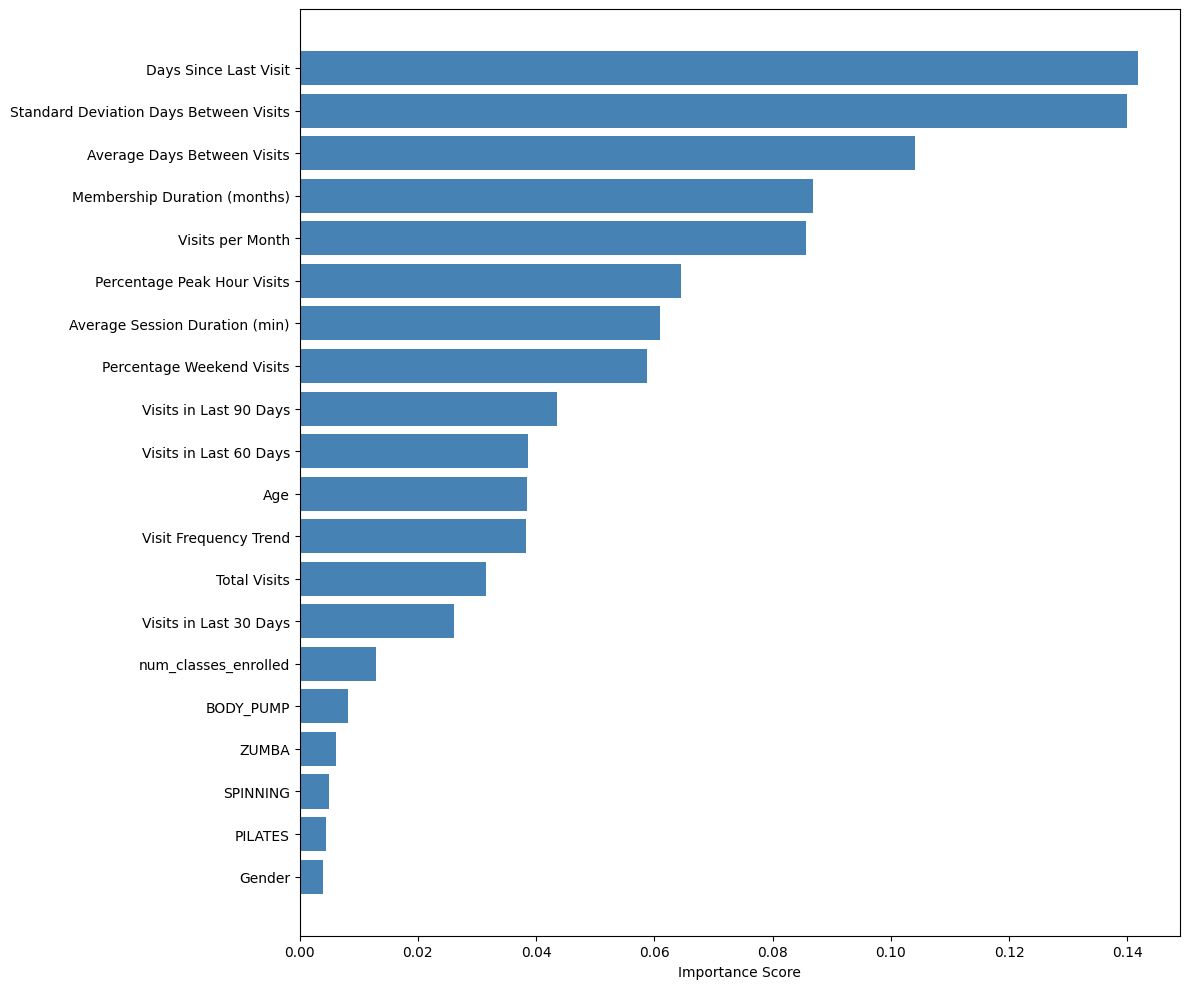


=== TOP 5 CHURN PREDICTORS ===
  Days Since Last Visit: 0.142
  Standard Deviation Days Between Visits: 0.140
  Average Days Between Visits: 0.104
  Membership Duration (months): 0.087
  Visits per Month: 0.086


In [10]:
# Feature importance
importance_df = get_feature_importance(model)

# Create readable labels for features
feature_labels = {
    'total_visits': 'Total Visits',
    'visits_per_month': 'Visits per Month',
    'avg_session_duration_min': 'Average Session Duration (min)',
    'days_since_last_visit': 'Days Since Last Visit',
    'avg_days_between_visits': 'Average Days Between Visits',
    'std_days_between_visits': 'Standard Deviation Days Between Visits',
    'visits_last_30_days': 'Visits in Last 30 Days',
    'visits_last_60_days': 'Visits in Last 60 Days',
    'visits_last_90_days': 'Visits in Last 90 Days',
    'pct_peak_hour_visits': 'Percentage Peak Hour Visits',
    'pct_weekend_visits': 'Percentage Weekend Visits',
    'visit_frequency_trend': 'Visit Frequency Trend',
    'membership_duration_months': 'Membership Duration (months)',
    'AGE': 'Age',
    'GENDER': 'Gender'
}

# Apply readable labels
importance_df['feature_label'] = importance_df['feature'].map(feature_labels).fillna(importance_df['feature'])

plt.figure(figsize=(12, 10))
importance_sorted = importance_df.sort_values('importance', ascending=True)
plt.barh(importance_sorted['feature_label'], importance_sorted['importance'], color='steelblue')
plt.xlabel('Importance Score')
plt.title('', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n=== TOP 5 CHURN PREDICTORS ===")
for _, row in importance_df.head(5).iterrows():
    print(f"  {row['feature_label']}: {row['importance']:.3f}")


## Churned vs Active Users Comparison

Let's compare the behavior patterns between users who churned and those who stayed.


In [7]:
# Compare key metrics between churned and active users
comparison_cols = ['visits_per_month', 'days_since_last_visit', 'avg_session_duration_min', 
                   'visit_frequency_trend', 'num_classes_enrolled']

churned = features_df[features_df['CHURNED'] == 1]
active = features_df[features_df['CHURNED'] == 0]

print("=== BEHAVIOR COMPARISON: CHURNED vs ACTIVE ===\n")
for col in comparison_cols:
    print(f"{col}:")
    print(f"  Churned: {churned[col].mean():.2f} (median: {churned[col].median():.2f})")
    print(f"  Active:  {active[col].mean():.2f} (median: {active[col].median():.2f})")
    print()


=== BEHAVIOR COMPARISON: CHURNED vs ACTIVE ===

visits_per_month:
  Churned: 3.89 (median: 1.49)
  Active:  1.05 (median: 0.54)

days_since_last_visit:
  Churned: 46.49 (median: 17.00)
  Active:  68.41 (median: 43.00)

avg_session_duration_min:
  Churned: 62.89 (median: 61.80)
  Active:  61.35 (median: 60.87)

visit_frequency_trend:
  Churned: 0.03 (median: 0.00)
  Active:  0.11 (median: -0.14)

num_classes_enrolled:
  Churned: 0.80 (median: 1.00)
  Active:  0.84 (median: 1.00)



## Identify At-Risk Active Users

Use the trained model to find currently active users who show similar patterns to those who churned.


In [8]:
# Predict churn risk for active users
risk_df = predict_churn_risk(model, features_df, active_only=True)

print("=== RISK DISTRIBUTION (Active Users) ===")
print(risk_df['risk_level'].value_counts())

print("\n=== TOP 10 AT-RISK USERS ===")
print(risk_df.head(10).to_string(index=False))


=== RISK DISTRIBUTION (Active Users) ===
risk_level
Low       156
Medium     30
High        4
Name: count, dtype: int64

=== TOP 10 AT-RISK USERS ===
 USER_ID  CHURNED  total_visits  visits_per_month  avg_session_duration_min  days_since_last_visit  avg_days_between_visits  std_days_between_visits  visits_last_30_days  visits_last_60_days  visits_last_90_days  pct_peak_hour_visits  pct_weekend_visits  visit_frequency_trend  membership_duration_months  AGE  GENDER  ZUMBA  BODY_PUMP  PILATES  SPINNING  num_classes_enrolled  churn_risk risk_level
   69470        0             8          1.935484                 62.875000                     46                10.571429                 9.675694                    0                    3                    5              0.625000            0.375000              -0.400000                    4.133333   29       1      0          0        0         0                     0    0.778547       High
   73092        0             6          1.323529 

In [9]:
# Save the trained model for later use
model_path = Path.cwd().parent / 'output' / 'churn_model.joblib'
save_model(model, str(model_path))


Model saved to: c:\Users\polri\Desktop\Projectes\gym-member-retention-app\output\churn_model.joblib
